# NETWORK ROBUSTNESS HANDOUT

Networks occur in many natural and man-made systems, including Financial Systems, Computer Systems (like the WWW and the Internet), Biological Systems (the brain, protein networks, etc.) and Social Systems (e.g., contact networks). Understanding something about the robustness of these networks, in the case of when nodes or edges are removed, is important if we want to engineer or protect these systems.

For further reading please refer to Chapter 8 of the Network Science book by Barabasi.

In this exercise we will recreate the experiments of Albert, Jeong and Barabási. You can see the paper at http://www.nature.com/nature/journal/v406/n6794/full/406378a0.html

We will analyse a number of artificial and real world networks in terms of their robustness to *failures* and *attacks*. We define a *failure* in a network as the *random* removal of a node (and its connected edges), whereas an *attack* is when we specifically remove targeted nodes (and their connected edges) based on some measure (e.g., max degree, max betweenness, etc.).

The attacks (or failures) are made one-by-one to the network until we remove a fraction $f$ of all the nodes $N$ in the original network. We then measure a number of network parameters to gauge their impact as a function of $f$: 
    
1. $S_c$, fraction of remaining nodes in the largest component
2. $<l>_c$, average path length of largest component
3. $D_c$, Diameter of the largest component 

We will conduct these experiments on a number of networks, Barabási-Albert (BA) networks, Erdös-Réyni (ER) networks and an airline network. Of course, in the case of the artificial networks we will want to repeat the analysis for many parameters and many instanes of the networks, so this may require significant computation. For reference see the figure below, also from Barabási. These graphs show the robustness of BA (scale-free) and ER networks, the top two graphs show $S$ the fraction of nodes in the giant component as a function of removals, circles are attacks and squares are failures. The lower two figures show average path length $<l>$ as a function of removals. The left hand graphs show ER networks and the right hand graphs show BA networks.

/content/robustness.png

## Robustness, good or bad?

Generally you might think of more robustness networks as a good thing. However, sometimes we would like networks to be less robust, or figure out the best way to make the network fail. A good example of this is when you are deciding who to vacinate against a particular disease given a social contact network. A vacination is effectively the removal of a specific node in the contact network as this person cannot get or transmit the disease to others. If you're very careful, and very lucky, you might be able to break the network apart by strategically attacking (vacinating) only a few nodes.

Airport networks are crucial for understanding the spread of world-wide pandemics. Air-travel is one of the quickest ways that diseases can spread across the globe. For the airport network, an attack is effectively the closure of an airport. In that case we want to find out if it's possible to break the network apart, and stop the disease spread, by only attacking a few nodes (closing a few airports).

## Import required libraries

In [1]:
from __future__ import unicode_literals #allow UTF characters in graph labels
import networkx as nx                 #import NetworkX
import numpy as np                    #import numpy for ...
#force drawing of graphs inline for ipython notebook
%matplotlib inline 
import matplotlib.pyplot as plt       #import matplotlib for plotting/drawing grpahs
import matplotlib.patches as mpatches #for legends in the graph
import random                         # for random choice function
import copy                           # this is used for making deep copies of lists
from tqdm import tqdm                 #nice library for progress bars
import sys                            #for writing output to stderr

## Defining our attack and fail functions

We now define 3 Python functions that we can use to remove nodes, either attacks of failures. We will use these functions repeatedly to affect the network.

In [2]:
def fail(G):                      #a python function that will remove a random node from the graph G
    n = random.choice(list(G.nodes()))  #pick a random node
    G.remove_node(n)              # remove that random node, attached edges automatically removed.
    
def attack_degree(G):                  #remove node with maximum degree
    degrees = G.degree()               # get dictionary where key is node id, value is degree
    max_degree = max(dict(degrees).values() ) # find maximum degree value from all nodes
    max_keys = [k for k,v in dict(degrees).items() if v==max_degree] #get all nodes who have the maximum degree (may be more than one)
    G.remove_node(max_keys[0])         #remove just the first node with max degree, we will remove others next
    
def attack_betweenness(G):                     # note - not currently used, but try it!
    betweenness = nx.betweenness_centrality(G) # get dictionary where key is node id and value is betweenness centrality
    max_betweenness = max(dict(betweenness).values() )    # find maximum degree value from all nodes
    max_keys = [k for k,v in dict(betweenness).items() if v==max_betweenness] #get all nodes who have the maximum degree (may be more than one)
    G.remove_node(max_keys[0])                 #remove just the first node with max degree, we will remove others next 

## Artificial Networks

Now we will generate a number of different networks using the in built NetworkX methods. Each of these network generators has a number of parameters (including network size), we will vary these somewhat to test their impact. However, it's advisable avoid doing networks which are very large as this will take too much time.

### Experiment parameters ###

Below are the parametes we will use to create the artificial networks (for the experiments) and other experimental parameters. Change these if you want to run with different network configurations


In [3]:
NetworkSize = 1000 #network size to use in experiments
ba_m = [3]         #list of m values to use, m indicate the number of new edges to add for every new node added in the BA model
p_values = [0.008] #p values to use for ER networks, p indicates probability of making an edge
repetitions = 1    #For each of the parameter settings above, how many unqiue graphs do we want to generate.

fraction_of_nodes_to_remove = 0.05 # remove until this fraction of all original nodes are removed
num_removals = int(fraction_of_nodes_to_remove * NetworkSize) #number of nodes to remove

### Create the artificial networks

Below we create our artificial networks and store them in two lists. We also make a deep copy, so we can re-use them whenever necessary. Don't forget, the experiments will actually destroy the networks by removing nodes, so in case we want to run the fail on *exactly* the same network as the attacks, we need to have a copy to work with.

In [4]:
ba_networks = [] #list to store BA networks,
er_networks = [] #list to store ER networks,
    
for m in ba_m: #create BA networks
    for r in range(repetitions):
        ba_networks.append(nx.barabasi_albert_graph(NetworkSize, m, r))

for p in p_values: #create ER networks
    for r in range(repetitions):
        er_networks.append(nx.erdos_renyi_graph(NetworkSize, p, r))
    
orig_er_networks = copy.deepcopy(er_networks) # make copies of the network lists a deep copy will copy the list and the items inside.
orig_ba_networks = copy.deepcopy(ba_networks)

## Measuring Original Network statistics

We now have some BA networks and some ER networks that we can analyse, we will measure the diameter $D$, the average path  length $<l>$ and the fraction of nodes in the giant component (although this will be 1.0 initially for the BA networks)

First we get all metrics for the BA networks, you'll notice the diameter is typically the same, and the average path length varies a little.

To make this more efficient we create a few functions. First we make a function that calculates the diameter and average path length at the same time (this is more effecient than doing both separately).

We then have a function for collecting the statistics in a single graph, then another function for collecting statistics from a list of graphs.

In [5]:
def diameter_ave_path_length(G):
    # We create our own function to do this so things are slightly faster, 
    # we can calculate diameter and avg path length at the same time
    max_path_length = 0
    total = 0.0
    for n in G: #iterate over all nodes
        path_length=nx.shortest_path_length(G, n) # generate shortest paths from node n to all others
        total += sum(path_length.values()) #total of all shortest paths from n
        if max(path_length.values()) > max_path_length: #keep track of longest shortest path we see.
            max_path_length = max(path_length.values())         
    try:
        avg_path_length = total / (G.order()*(G.order() - 1))
    except ZeroDivisionError:
        avg_path_length = 0.0
    return max_path_length, avg_path_length

def all_network_statistics(nw_list): 
    # a function that takes in a list of networks and returns 3 lists of same length listing the diameter, average 
    # path length and giant component size for all the networks
    diameters = []
    path_lengths = []
    S = []
    for n in nw_list:
        d,l,s = a_network_statistics(n)
        diameters.append(d)
        path_lengths.append(l)
        S.append(s)
    return (diameters, path_lengths, S)

def a_network_statistics(n):
    
    Gcc=sorted(nx.connected_components(n), key = len, reverse=True)
    G0=n.subgraph(Gcc[0])
    d,l = diameter_ave_path_length(G0)
    s = float(G0.order()) / float(NetworkSize)
    return d,l,s

print(all_network_statistics(ba_networks)) #calculate and print all statistics of the BA networks.

([6], [3.4805925925925925], [1.0])


Now we will do the same thing for the ER networks, notice that the value of p=0.08 was selected to create networks with approximately the same average path length as the BA model with m=3. From analytical results we know that $$<l>_{ER} = \frac{\ln(N)}{\ln(N \times p)}$$ 


In [6]:
print(all_network_statistics(er_networks))

([7], [3.5376536536536536], [1.0])


## Failures

Now we will gradually fail our BA and ER Networks.

Note that these calculations take a significant amount of time, because after each failure, and for each network we measure the diameter and average path length.

In [7]:
# This is needed if we just want to rerun this cell and not have to create the networks again after we destroy them
er_networks = copy.deepcopy(orig_er_networks)
ba_networks = copy.deepcopy(orig_ba_networks)



def experiments(networks, removals, run_fail=True, measure_every_X_removals=20):
    # the below list will record the average statistic for all networks, a new entry in the list is added after each fail
    ave_diameters = []
    ave_path_lengths = []
    ave_S = []
    sys.stderr.write("---- Starting Experiments ---- \n")
    sys.stderr.flush()
    for x in tqdm(range(removals)):                    
        for n in networks:
            if run_fail:
                fail(n)
            else:
                attack_degree(n)
        if x % measure_every_X_removals == 0:            
            d, l, s = all_network_statistics(networks)
            ave_diameters.append(np.mean(d))
            ave_path_lengths.append(np.mean(l))
            ave_S.append(np.mean(s))
    sys.stderr.write("---- Experiments Finished ---- \n")
    sys.stderr.flush()
    return ave_diameters, ave_path_lengths, ave_S
                
er_ave_diameters, er_ave_path_lengths, er_ave_S = experiments(er_networks, num_removals)
ba_ave_diameters, ba_ave_path_lengths, ba_ave_S = experiments(ba_networks, num_removals)

print("\n ----All Experiments Finisheds ---- \n")

---- Starting Experiments ---- 
100%|██████████| 50/50 [00:39<00:00,  1.27it/s]
---- Experiments Finished ---- 
---- Starting Experiments ---- 
100%|██████████| 50/50 [00:26<00:00,  1.91it/s]
---- Experiments Finished ---- 



 ----All Experiments Finisheds ---- 



## Plotting Failure

Below we plot the results from the failure experiments above.

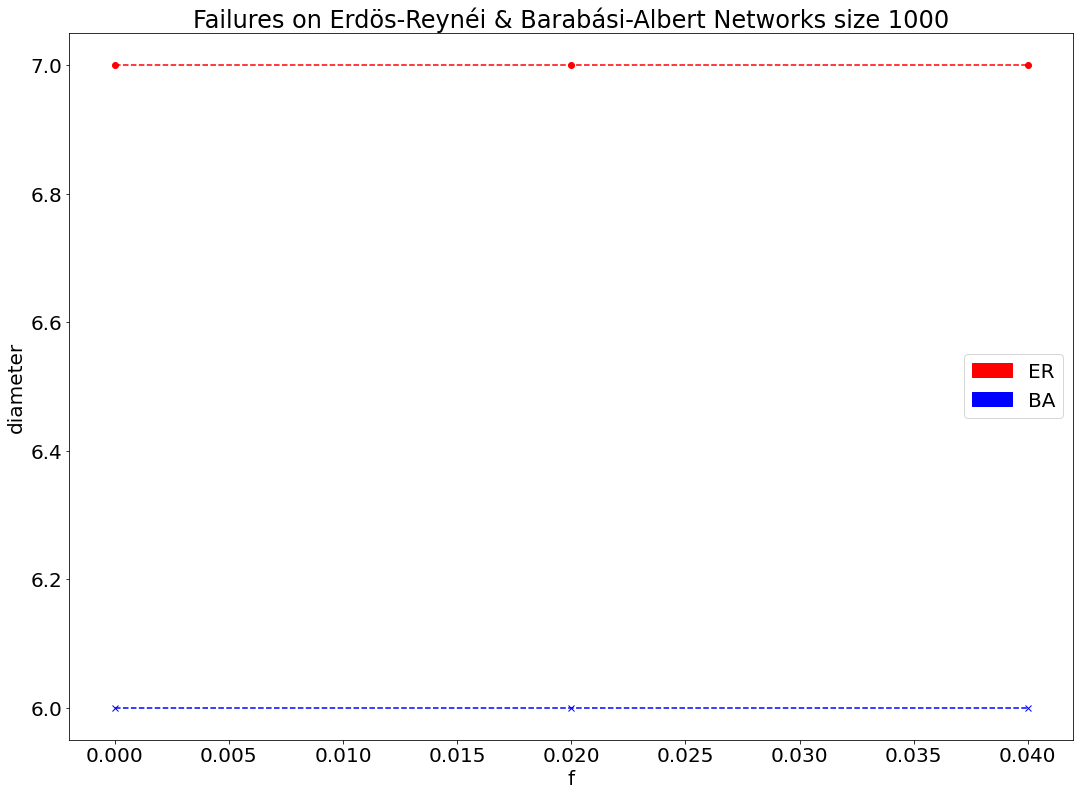

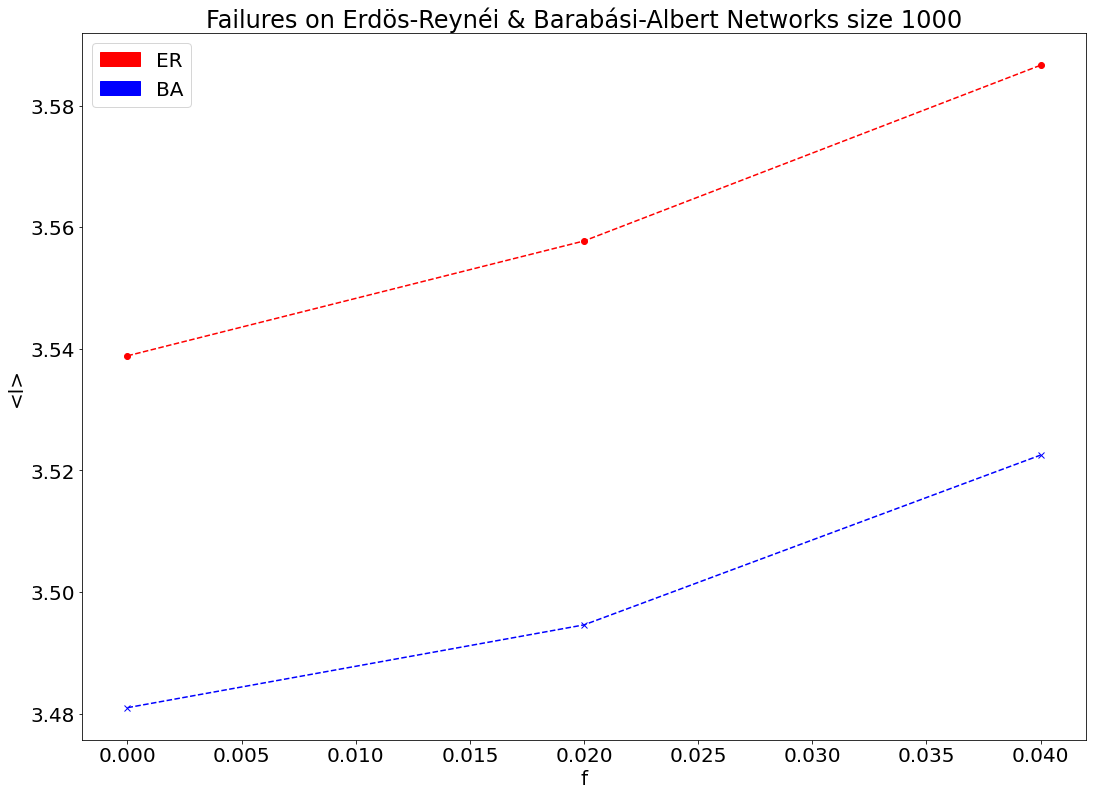

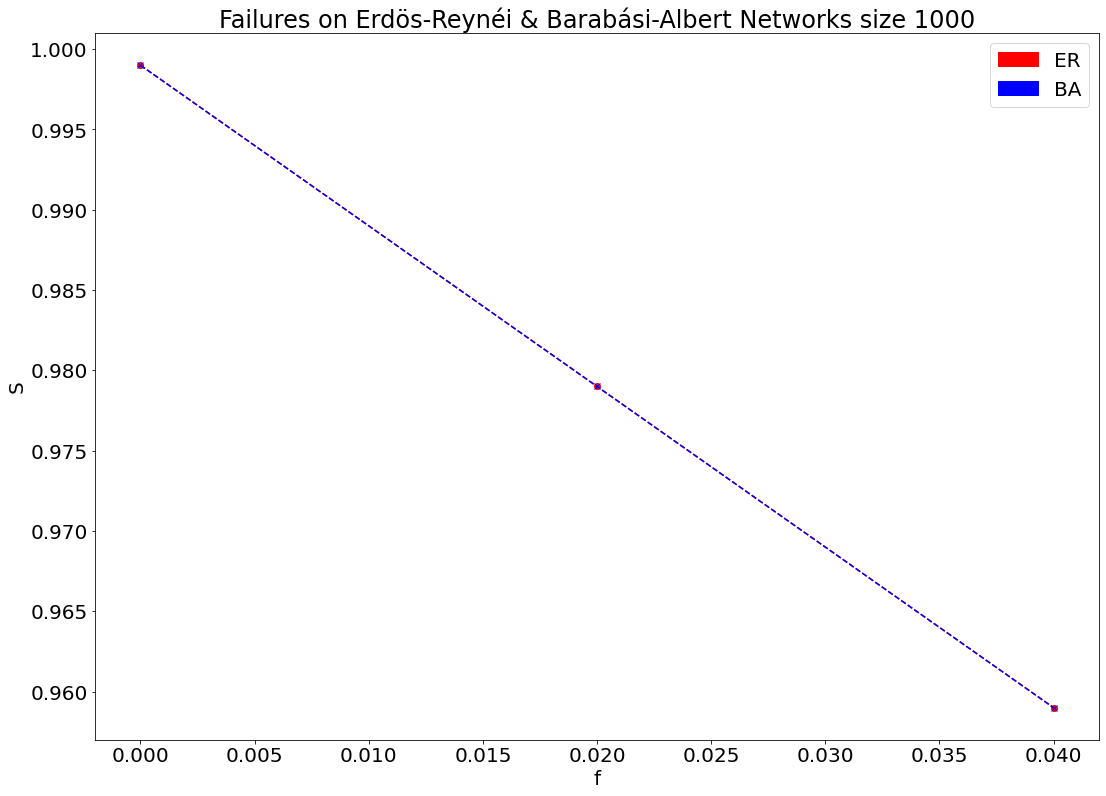

In [8]:
#plotting stuff...
xvalues = [(float(x)/float(NetworkSize)) * 20 for x in range(len(er_ave_diameters))]
fig_size= [18,13]
plt.rcParams.update({'font.size': 20, "figure.figsize": fig_size})

# Plot diameter
plt.plot(xvalues, er_ave_diameters, '--or', xvalues, ba_ave_diameters, '--xb')
red_patch = mpatches.Patch(color='red', label='ER')
blue_patch = mpatches.Patch(color='blue', label='BA')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('f')
plt.ylabel('diameter')
plt.title('Failures on Erdös-Reynéi & Barabási-Albert Networks size ' + str(NetworkSize))
plt.show()

# Plot average path length
plt.plot(xvalues, er_ave_path_lengths, '--or', xvalues, ba_ave_path_lengths, '--xb')
red_patch = mpatches.Patch(color='red', label='ER')
blue_patch = mpatches.Patch(color='blue', label='BA')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('f')
plt.ylabel('<l>')
plt.title('Failures on Erdös-Reynéi & Barabási-Albert Networks size ' + str(NetworkSize))
plt.show()

# Plot fraction of nodes in giant component
plt.plot(xvalues, er_ave_S, '--or', xvalues, ba_ave_S, '--xb')
red_patch = mpatches.Patch(color='red', label='ER')
blue_patch = mpatches.Patch(color='blue', label='BA')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('f')
plt.ylabel('S')
plt.title('Failures on Erdös-Reynéi & Barabási-Albert Networks size ' + str(NetworkSize))
plt.show()

## Attack Experiments

Now we will run degree-based attacks on the networks, where we remove the nodes with the highest degree first

In [9]:
# This is needed if we just want to rerun this cell and not have to create the networks again after we destroy them
er_networks = copy.deepcopy(orig_er_networks)
ba_networks = copy.deepcopy(orig_ba_networks)

er_ave_diameters, er_ave_path_lengths, er_ave_S = experiments(er_networks, num_removals, run_fail=False)
ba_ave_diameters, ba_ave_path_lengths, ba_ave_S = experiments(ba_networks, num_removals, run_fail=False)
        
print("--Experiments Finished--")

---- Starting Experiments ---- 
100%|██████████| 50/50 [00:30<00:00,  1.62it/s]
---- Experiments Finished ---- 
---- Starting Experiments ---- 
100%|██████████| 50/50 [00:24<00:00,  2.07it/s]
---- Experiments Finished ---- 


--Experiments Finished--


## Plotting attacks

Now we plot graphs showing the attacks on both networks

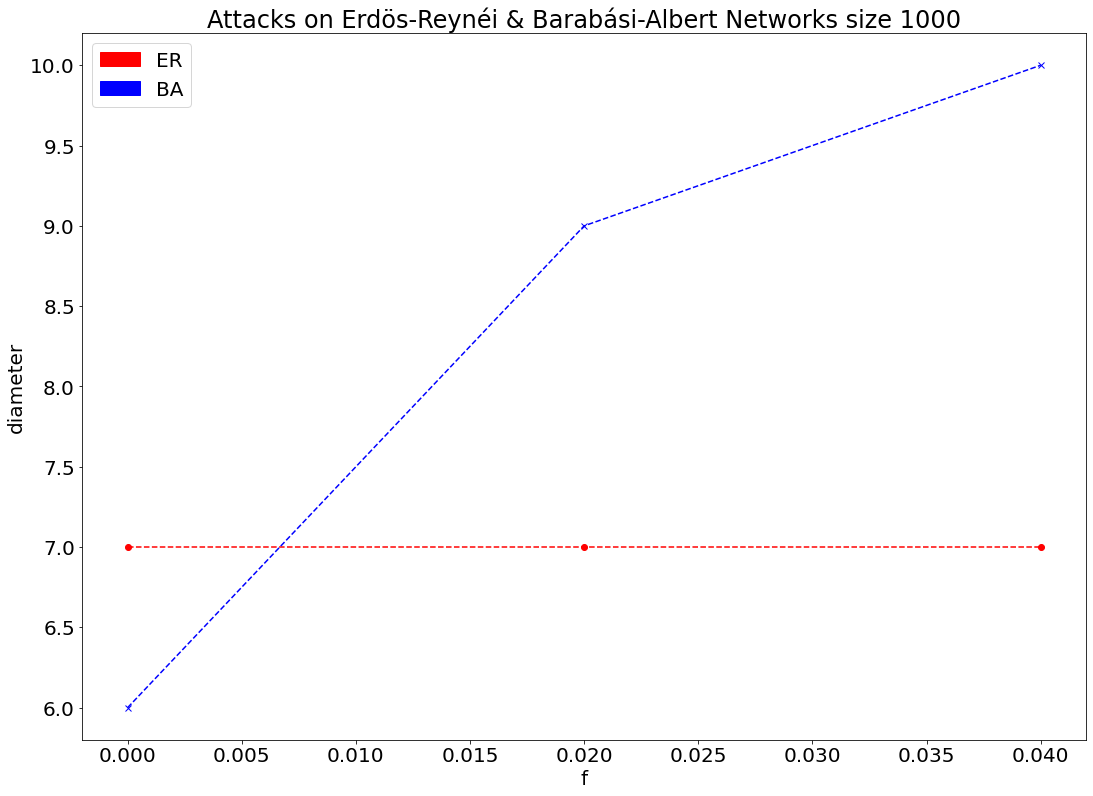

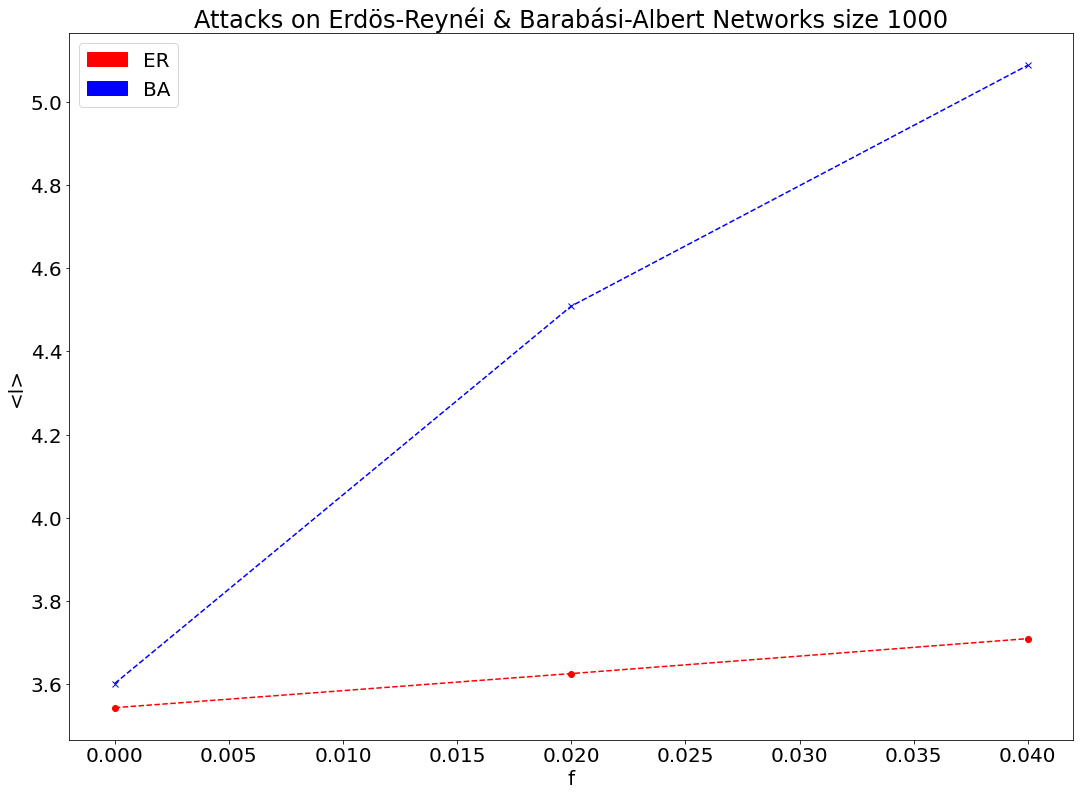

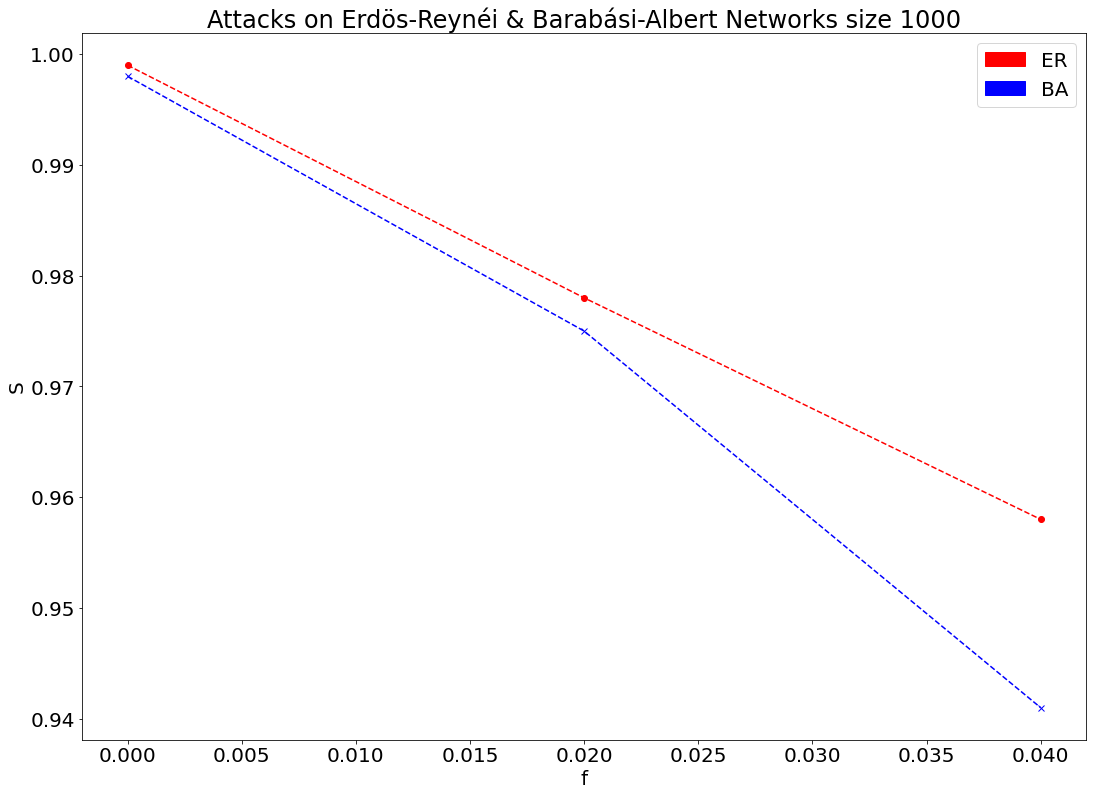

In [10]:
#plotting stuff...
xvalues = [(float(x)/float(NetworkSize)) * 20 for x in range(len(er_ave_diameters))]
fig_size= [18,13]
plt.rcParams.update({'font.size': 20, "figure.figsize": fig_size})

# Plot diameter
plt.plot(xvalues, er_ave_diameters, '--or', xvalues, ba_ave_diameters, '--xb')
plt.xlabel('f')
plt.ylabel('diameter')
plt.title('Attacks on Erdös-Reynéi & Barabási-Albert Networks size ' + str(NetworkSize))
red_patch = mpatches.Patch(color='red', label='ER')
blue_patch = mpatches.Patch(color='blue', label='BA')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

# Plot average path length
plt.plot(xvalues, er_ave_path_lengths, '--or', xvalues, ba_ave_path_lengths, '--xb')
red_patch = mpatches.Patch(color='red', label='ER')
blue_patch = mpatches.Patch(color='blue', label='BA')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('f')
plt.ylabel('<l>')
plt.title('Attacks on Erdös-Reynéi & Barabási-Albert Networks size ' + str(NetworkSize))
plt.show()

# Plot fraction of nodes in giant component
plt.plot(xvalues, er_ave_S, '--or', xvalues, ba_ave_S, '--xb')
red_patch = mpatches.Patch(color='red', label='ER')
blue_patch = mpatches.Patch(color='blue', label='BA')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('f')
plt.ylabel('S')
plt.title('Attacks on Erdös-Reynéi & Barabási-Albert Networks size ' + str(NetworkSize))
plt.show()

## Airline Network

Now we can do the same experiments with the Airline Network from the previous class. We will ignore edge direction in this case, as direction can complicate the component definitions. This may take some time as the airline network is large has over 3000 nodes and nearly 40000 edges.


In [11]:
with open('edgelist.csv', 'rb') as file_handle:
    next(file_handle, '')   # skip the header line (NOTE the first list in the CSV file doesn't contain an edge)
    G = nx.read_edgelist(file_handle, delimiter=',',
                         nodetype=str, data=(('weight', float),), encoding="utf-8")
G_c = G.copy()
NetworkSize = G.order()

anf_ave_diameters, anf_ave_path_lengths, anf_ave_S = experiments([G], int(NetworkSize * 0.8), run_fail=True, measure_every_X_removals=200)
ana_ave_diameters, ana_ave_path_lengths, ana_ave_S = experiments([G_c], int(NetworkSize * 0.8), run_fail=False, measure_every_X_removals=200)

---- Starting Experiments ---- 
100%|██████████| 2628/2628 [14:14<00:00,  3.08it/s]
---- Experiments Finished ---- 
---- Starting Experiments ---- 
100%|██████████| 2628/2628 [04:10<00:00, 10.49it/s]  
---- Experiments Finished ---- 


## Plotting Airline Network

Now we plot the result of the attacks and failures on the airline network. You'll see something interesting regarding the average path length...try to think about some consequences of this finding.


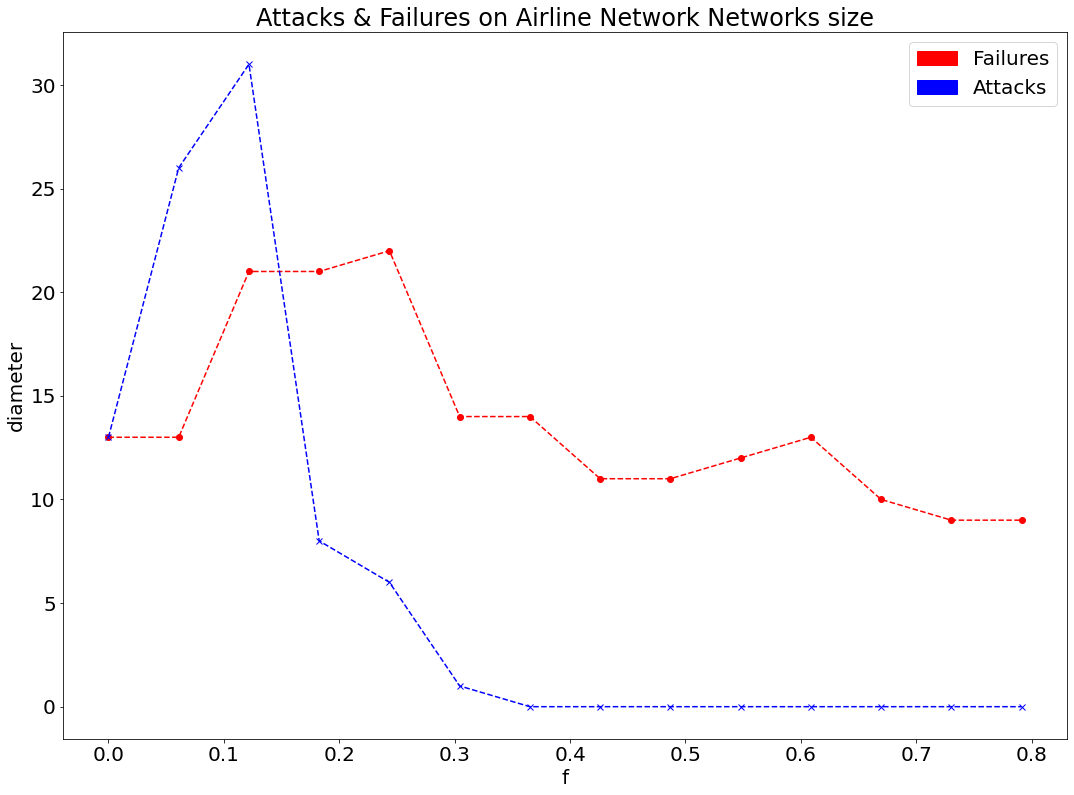

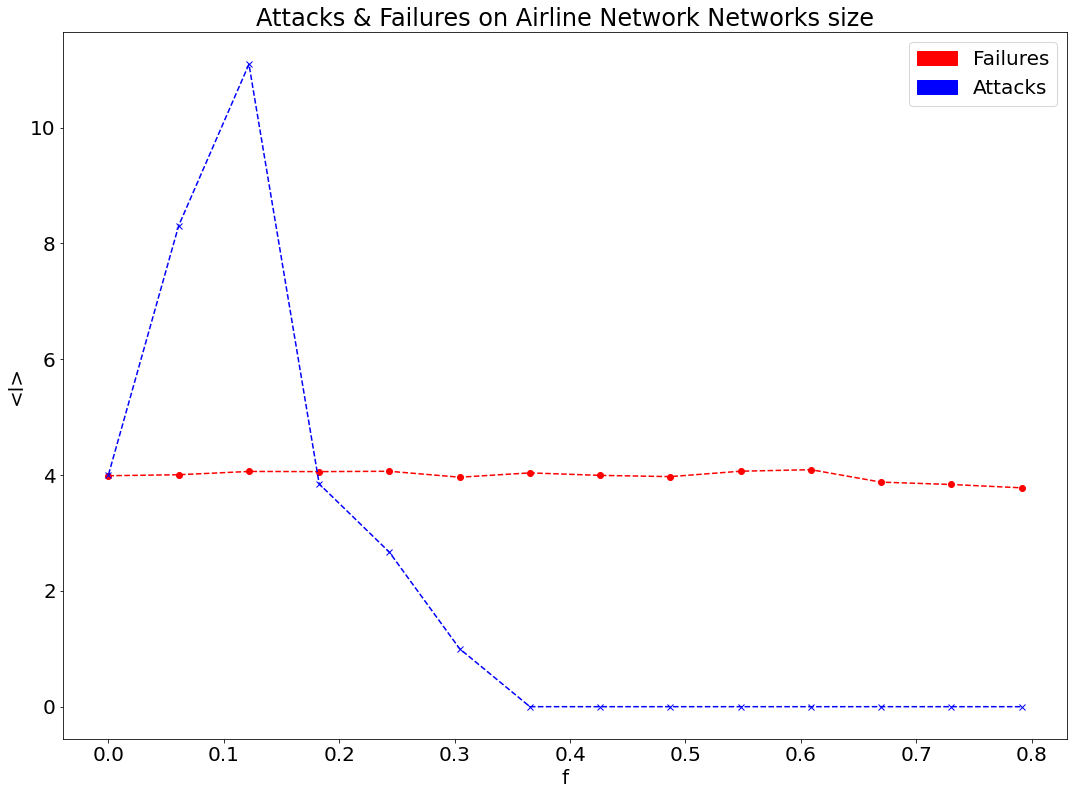

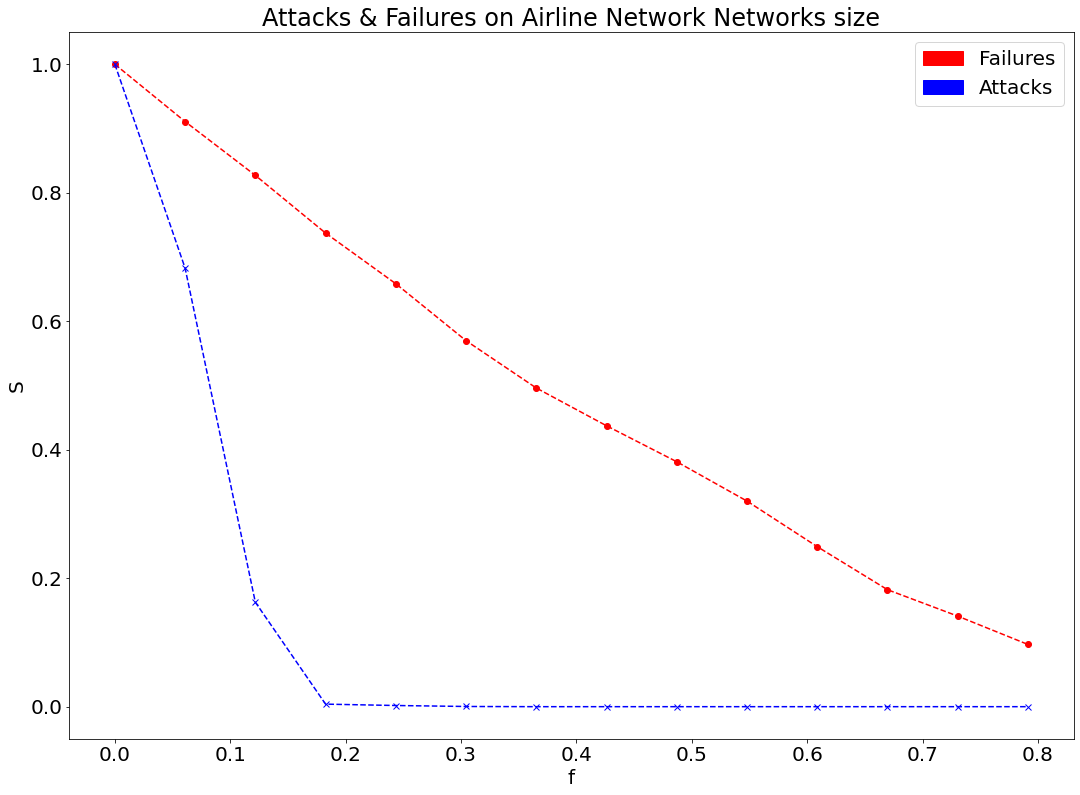

In [12]:
fig_size= [18,13]
plt.rcParams.update({'font.size': 20, "figure.figsize": fig_size})
xvalues = [(float(x)/float(NetworkSize)) * 200 for x in range(len(anf_ave_diameters))]

# Plot diameter
plt.plot(xvalues, anf_ave_diameters, '--or', xvalues, ana_ave_diameters, '--xb')
plt.xlabel('f')
plt.ylabel('diameter')
plt.title('Attacks & Failures on Airline Network Networks size')
red_patch = mpatches.Patch(color='red', label='Failures')
blue_patch = mpatches.Patch(color='blue', label='Attacks')
plt.legend(handles=[red_patch, blue_patch])
plt.show()

# Plot average path length
plt.plot(xvalues, anf_ave_path_lengths, '--or', xvalues, ana_ave_path_lengths, '--xb')
red_patch = mpatches.Patch(color='red', label='Failures')
blue_patch = mpatches.Patch(color='blue', label='Attacks')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('f')
plt.ylabel('<l>')
plt.title('Attacks & Failures on Airline Network Networks size')
plt.show()

# Plot fraction of nodes in giant component
plt.plot(xvalues, anf_ave_S, '--or', xvalues, ana_ave_S, '--xb')
red_patch = mpatches.Patch(color='red', label='Failures')
blue_patch = mpatches.Patch(color='blue', label='Attacks')
plt.legend(handles=[red_patch, blue_patch])
plt.xlabel('f')
plt.ylabel('S')
plt.title('Attacks & Failures on Airline Network Networks size')
plt.show()    


## Questions & Further Work

If you have your own network data, or you're interested in other networks available online, now is a good time to repeat the robustness experiments on these networks. You can use the code above (for the airline network) to repeat the experiments on other networks.